<img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Roberto Compañy

***
## Señal con ruido blanco


Un receptor de comunicaciones posee un frontend analógico que recibe señales moduladas en PAM (Pulse Amplitude Modulation), por medio de pulsos de forma exponencial. El canal por el cual viajan estos pulsos es un canal AWGN (Additive White Gaussian Noise), por lo cual la señal recibida se verá degradada notablemente. En principio, se puede suponer que afecta de forma independiente a cada muestra de la señal.

Se dispone una trama digitalizada muestrada a 20 samples / pulso. La trama contiene un header de 16 bytes donde cada byte es: 10101100.

La modulación empleada es antipodal:
pulso positivo  -> bit 1
pulso negativo -> bit 0

Objetivos principales:
- Detectar la secuencia de bits recibida de forma confiable
- Investigar diferentes métodos de demodulación


Notas:

- La señal se encuentra sincronizada a nivel muestra. Por esta razón, la muestra 0 corresponde al comienzo de un pulso exponencial.
- Tener en cuenta que el objetivo es recuperar la información, lo cual no implica recuperar fielmente la señal enviada. Esto es clásico en problemas de comunicaciones: sabemos la forma de la modulación (la forma de los pulsos y como se modulan), lo que no sabemos es con qué valores fueron modulados.

Para ello se pide:


**PARTE 1**

a) Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes. 
¿Es óptimo el filtro elegido para detectar la información en forma confiable?

b) Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¿es óptimo este umbral?


<div class="alert alert-block alert-success">
Para resolver esta parte del práctico, se probaron distintos caminos los cuales se detallan a continuación:
En primer lugar, se analizo de forma general la señal:
</div>

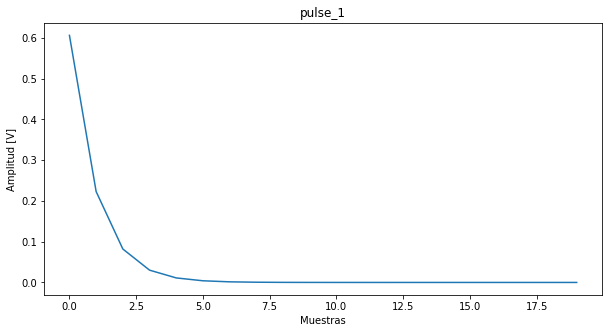

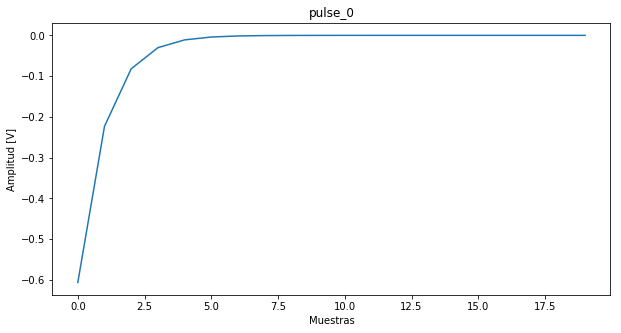

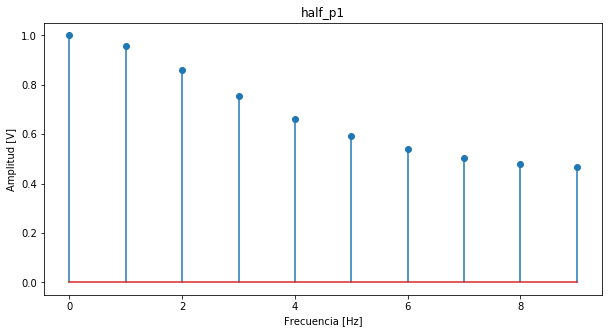

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sc
from scipy import signal as sig

plt.close( 'all' )

pulse_1 = np.load('pulse.npy')
pulse_0 = pulse_1 * -1
signal = np.load('signal.npy')

plt.figure( 1, (10,5) )
plt.plot( pulse_1 )
plt.title( 'pulse_1')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [V]')
plt.show()

plt.figure( 2, (10,5) )
plt.plot( pulse_0 )
plt.title( 'pulse_0')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [V]')
plt.show()

N_p1 = len(pulse_1)
spectrum_p1 = np.abs(sc.fft(pulse_1))
spectrum_p1 = (1/max(spectrum_p1)) * spectrum_p1     #Amplitud Normalizada\n",
half_p1 = spectrum_p1[:N_p1//2]

plt.figure( 3, (10,5) )
plt.stem( half_p1 )
plt.title( 'half_p1')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [V]')
plt.show()

<div class="alert alert-block alert-success">
Se calculo la varianza dado que es un indicador del ruido en la señal
</div>

In [9]:
print("Varianza de la señal: " + str(signal.var()))

Varianza de la señal: 0.38175312102671116


<div class="alert alert-block alert-success">
La señal original tiene 32560 muestras y como esta sobre muestrreada a 20 samples / pulso; existen 1628 pulsos.<br/>
La primer prueba consiste en tomar la primer muestra de cada 20.
</div>

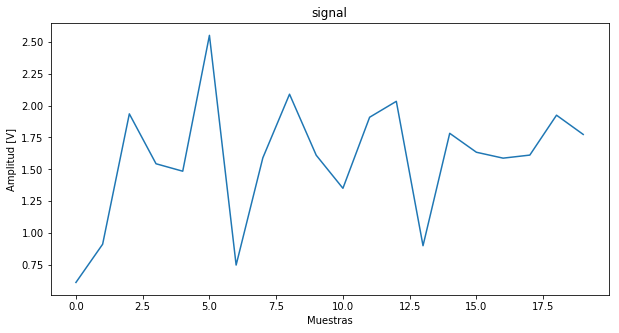

In [10]:
N_vent      = 1628
signal_vent = [0.0]
signal_vent = np.pad(signal_vent, (0,N_vent-1), 'constant', constant_values=(0, 0))

x=0
y=0
for i in signal_vent:
    signal_vent[x] = signal[y]
    x = x + 1
    if y == 0:
        y = 19
    else:
        y = y + 20


plt.figure( 4, (10,5) )
plt.plot( signal_vent[:20] )
plt.title( 'signal')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [V]')
plt.show()

<div class="alert alert-block alert-success">
Se realizo una prueba promediando de a 20 muestras y registrarlo en un nuevo vector.
</div>

signal.var() = 0.38175312102671116
signal_vent.var() = 0.35542260316280266


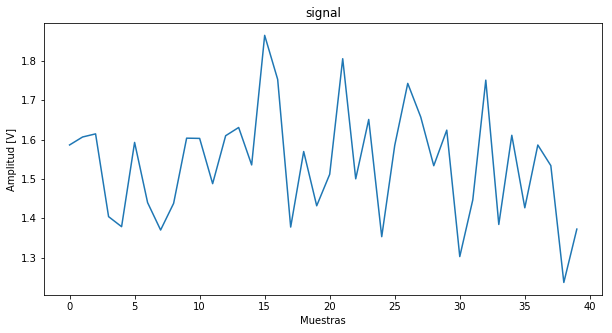

In [11]:
N_pulse_vent = 20
pulse_vent   = [0.0]
pulse_vent   = np.pad(pulse_vent, (0,N_pulse_vent-1), 'constant', constant_values=(0, 0))

promedio = 0.0
x=0
y=0
p=19
p_vent = 0
for i in signal_vent:
    promedio = promedio + signal[y]    
    if y == p:
        signal_vent[x] = promedio / 20
        promedio = 0.0
        p_vent= 0
        x = x + 1
        p = p + 20

    y = y + 1
    p_vent = p_vent + 1

print('signal.var() = ' + str( signal.var() ))
print('signal_vent.var() = ' + str( signal_vent.var() ))
    

plt.figure( 4, (10,5) )
plt.plot( signal_vent[:40] )
plt.title( 'signal')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [V]')
plt.show()

<div class="alert alert-block alert-success">
Se aplico filtro promediador y diferenciador a la señal
</div>

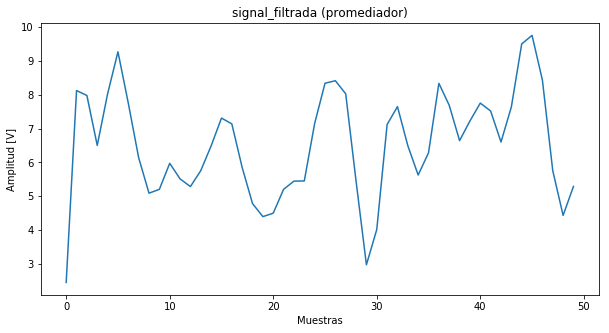

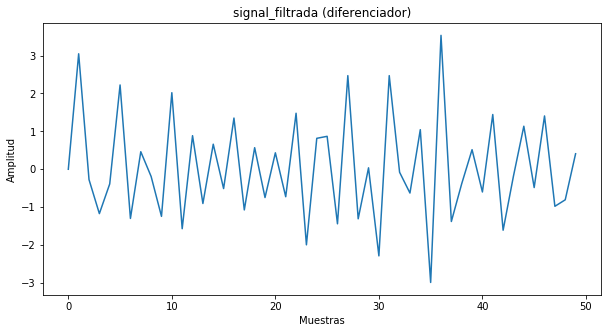

In [12]:
## Filtro promediador
fil_promediador = np.array([1, 1])
signal_filtrada_p = sig.filtfilt(fil_promediador, 1, signal)
plt.figure( 6, (10,5) )
plt.plot( signal_filtrada_p[:50] )
plt.title( 'signal_filtrada (promediador)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [V]')
plt.show()

# Filtro diferenciador para detectar flancos
fil_diferenciador = np.array([-1, 1])
signal_filtrada_d = sig.filtfilt(fil_diferenciador, 1, signal)
plt.figure( 5, (10,5) )
plt.plot( signal_filtrada_d[:50] )
plt.title('signal_filtrada (diferenciador)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()

<div class="alert alert-block alert-danger">
a) Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes. ¿Es óptimo el filtro elegido para detectar la información en forma confiable?
</div>

<div class="alert alert-block alert-info">
Analizando la DFT de la señal se advierte que se encuentra presente en todo el espectro por lo que cualquier filtro la afectara. Se utilizó la herramienta pyFDA para desarrollar distintos filtros FIR e IIR pero sin lograr una mejora real en la señal. Se deja aplicado el filtro promediador y con seguridad no es el óptimo (en espera de la clase en donde se explique como calcular el filtro adecuado para este tipo de señales).
</div>

<div class="alert alert-block alert-danger">
b) Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¿es óptimo este umbral?
</div>

In [15]:
# Se utilizará la media para determinal el umbral de dicision.
media = signal_filtrada_p.mean()
print('media = ' + str( media ))

N_palabra = 8
palabra   = [0.0]
palabra   = np.pad(palabra, (0,N_palabra-1), 'constant', constant_values=(0, 0))

x=0
y=1
for i in signal_vent:
    if signal_filtrada_p[y] > media:
        palabra[x] = 1
    else:
        palabra[x] = 0
    x = x + 1
    y = y + 20

print('palabra = ' + str(palabra))


media = 5.99771611058345
palabra = [1. 0. 1. 0. 1. 1. 0. 0.]


**PARTE 2**

a) Repetir el procedimiento para la parte 1, pero utilizar el filtro y el umbral óptimo.
